In [1]:
import parser
import re
import argparse
import os
import shutil
import time
import math
import logging

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
import torchvision.datasets
# from torchvision import models


from mean_teacher import datasets, data, losses, ramps, cli, models
from mean_teacher.run_context import RunContext
from mean_teacher.data import NO_LABEL
from mean_teacher.utils import *
from uncertainty import unc_losses

import matplotlib.pyplot as plt
from visdom import Visdom

LOG = logging.getLogger('main')

best_prec1 = 0
global_step = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters

In [2]:
class args:
    env = 'ssl_hardunc_exercise3'
    
    workers = 4
    
    # data set
    train_subdir = 'train'    
    eval_subdir = 'test'
    labels = '/home/bdggj/Documents/facade_defects/semi-supervised/data-local/labels/facade/exersize_labeled_list3.txt'
    dataset = 'facade'
    
    # model
    pretrained = True
    arch = models.resnet101
    
    epochs = 40
    start_epoch = 0
    labeled_batch_size = 32
    exclude_unlabeled = False
    batch_size = 64
    
    lr = 0.001
    initial_lr = 0.0
    lr_rampup = 0 
    lr_rampdown_epochs = 80
    step = 1
    momentum = 0.9
    nesterov = False
    weight_decay = 5e-5
    ema_decay = 0.9997
    consistency = 10
    consistency_type = 'mse'
    consistency_rampup = 5
    logit_distance_cost = 0.01
    
    checkpoint_epochs = 1
    evaluation_epochs = 1
    print_freq = 10

    evaluate = None 
    
    uncertainty = True
    unc_filter = 'hard'
    unc_beta = 3
    rho = 0.8
    thre_epoch = 12
    

    

In [3]:
global global_step  # Changing Global Variable From Inside a Function
global best_prec1

context = RunContext(_, 0)
training_log = context.create_train_log("training")
validation_log = context.create_train_log("validation")
ema_validation_log = context.create_train_log("ema_validation")


# Supplementary functions

In [4]:
def update_ema_variables(model, ema_model, alpha, global_step):
    # Use the true average until the exponential average is more correct
    alpha = min(1 - 1 / (global_step + 1), alpha)
    for ema_param, param in zip(ema_model.parameters(), model.parameters()):
        ema_param.data.mul_(alpha).add_(1 - alpha, param.data)
        # θ'_t = alpha*θ'_t-1 + (1 - alpha)*θ_t

In [5]:
def adjust_learning_rate(optimizer, epoch, step_in_epoch, total_steps_in_epoch):
    lr = args.lr
    epoch = epoch + step_in_epoch / total_steps_in_epoch

    # LR warm-up to handle large minibatch sizes from https://arxiv.org/abs/1706.02677
    lr = ramps.linear_rampup(epoch, args.lr_rampup) * (args.lr - args.initial_lr) + args.initial_lr

    # Cosine LR rampdown from https://arxiv.org/abs/1608.03983 (but one cycle only)
    step = args.step
    
    if args.lr_rampdown_epochs:    
        if (epoch+1) % step == 0:
            assert args.lr_rampdown_epochs >= args.epochs
            lr *= ramps.cosine_rampdown(epoch, args.lr_rampdown_epochs)
            

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def get_current_consistency_weight(epoch):
    # Consistency ramp-up from https://arxiv.org/abs/1610.02242
    return args.consistency * ramps.sigmoid_rampup(epoch, args.consistency_rampup)

In [6]:
def unc_list(ema_logit, minibatch_size, epoch, filter = 'hard', beta = 2, rho = 0.5, E = 15):

    class HLoss(nn.Module):
        def __init__(self):
            super(HLoss, self).__init__()

        def forward(self, x):
            b = F.softmax(x, dim=1) * F.log_softmax(x, dim=1)
            b = -1.0 * b.sum()
            return b

    criterion = HLoss()
    ema_map = np.zeros((minibatch_size, 1))

    for j in range(0, minibatch_size):
        # prediction=ema_logit[j,:].data.cpu().numpy()

        ema_map[j, 0] = criterion(ema_logit[j, :].view((1, ema_logit.size()[1]))).data.cpu().numpy()
    
    
    #map_hard
    
    num = (epoch + 1) * beta - 1
#     print(num)

    if num > minibatch_size - 1:
        num = minibatch_size - 1
    sort_map = np.sort(ema_map, axis=0)

    thresold = sort_map[num, 0]
    map_hard = np.zeros((minibatch_size, 1))
    for k in range(0, minibatch_size):
        if ema_map[k, 0] <= thresold:
            map_hard[k, 0] = 1
    map_hard_len = np.sum(list(map(lambda x:x>0, map_hard)))
    
    #map_prob

    namelist = np.argsort(ema_map, axis=0)

    last_keep_rate = rho * epoch / E
    if last_keep_rate > 1:
        last_keep_rate = 1
    if epoch > E:
        last_keep_rate = 1


    prob = np.zeros((minibatch_size, 1))
    for m in range(0, minibatch_size):
        keep_rate = 1 - (m / minibatch_size) * (1 - last_keep_rate)
        r = np.random.binomial(n=1, p=keep_rate)
        prob[namelist[m, 0], 0] = r
    map_prob = prob
    map_prob_len = np.sum(list(map(lambda x:x>0, map_prob)))
    
    #map_combine

    map_combine = map_hard + map_prob

    for i in range(0, minibatch_size):
        if map_combine[i, 0] > 1:
            map_combine[i, 0] = 1
        else:
            map_combine[i, 0] = 0
    map_combine_len = np.sum(list(map(lambda x:x>0, map_combine)))


    if filter == 'hard':
        return map_hard, map_hard_len
    elif filter == 'prob':
        return map_prob, map_prob_len
    else:
        return map_combine, map_combine_len

In [7]:
# def accuracy(output, target, topk=(1,)):
#     """Computes the precision@k for the specified values of k"""
#     maxk = max(topk)
#     labeled_minibatch_size = max(target.ne(NO_LABEL).sum(), 1e-8)

#     _, pred = output.topk(maxk, 1, True, True) #pred is the index
#     pred = pred.t() #transpose
#     correct = pred.eq(target.view(1, -1).expand_as(pred))

#     res = []
#     for k in topk:
#         correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
#         res.append(correct_k.mul_(100.0 / labeled_minibatch_size))  # percantage form of acc
#     return res

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    labeled_minibatch_size = max(target.ne(NO_LABEL).sum(), 1e-8)

    _, pred = output.topk(maxk, 1, True, True) #pred is the index
    pred = pred.t() #transpose
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
#         res.append(correct_k.mul_(100.0 / labeled_minibatch_size))  # percantage form of acc
        res.append(correct_k.mul_(100.0))
    
    return res

In [8]:
def unc_acc(map_unc, logit, target, topk=(1,2)):
#         print(target.size())
    # uncertainty filter based accuracy
        filter_logit = np.zeros((int(np.sum(map_unc.cpu().numpy())),logit.size()[1]))
        filter_target = np.zeros((int(np.sum(map_unc.cpu().numpy())), 1))
        num_filtered = 0
        target = target.cpu().numpy()
        
#         print(filter_target.shape)
        for k in range(0,len(map_unc)):
            if map_unc[k,0] > 0: 
#                 print('yes')
                filter_logit[num_filtered] = F.softmax(logit[k].view(1,logit.size()[1]),dim=1).cpu().data.numpy()
                filter_target[num_filtered] = target[k]
                num_filtered = num_filtered + 1
                                 
        if num_filtered > 0:
            target = torch.autograd.Variable(torch.LongTensor(target)) 
            filter_target = torch.autograd.Variable(torch.LongTensor(filter_target))  
            filter_logit = torch.autograd.Variable(torch.LongTensor(filter_logit)).cuda()  
            filter_prec1, _ = accuracy(filter_logit.cpu().data, filter_target.data, topk=topk)
            total_prerc1, _ = accuracy(F.softmax(logit,dim=1).data.cpu(), target.data, topk=topk)
        else:
            filter_prec1=0
            total_prerc1, _ = accuracy(F.softmax(logit,dim=1).data.cpu(), target.data, topk=topk)
        
        return filter_prec1, total_prerc1, num_filtered

In [9]:
def create_data_loaders(train_transformation,
                        eval_transformation,
                        datadir,
                        args):
    traindir = os.path.join(datadir, args.train_subdir)
    evaldir = os.path.join(datadir, args.eval_subdir)

    assert_exactly_one([args.exclude_unlabeled, args.labeled_batch_size])
    # Refer to cli.py and utils.py, need to ensure that there is 0 or exact number of labeled data in a batch

    dataset = torchvision.datasets.ImageFolder(traindir, train_transformation)

    if args.labels:
        with open(args.labels) as f:
            labels = dict(line.split(' ') for line in f.read().splitlines())
        labeled_idxs, unlabeled_idxs = data.relabel_dataset(dataset, labels)

    if args.exclude_unlabeled:
        sampler = SubsetRandomSampler(labeled_idxs)
        batch_sampler = BatchSampler(sampler, args.batch_size, drop_last=False)
    elif args.labeled_batch_size:
        batch_sampler = data.TwoStreamBatchSampler(
            unlabeled_idxs, labeled_idxs, args.batch_size, args.labeled_batch_size)
    else:
        assert False, "labeled batch size {}".format(args.labeled_batch_size)

    train_loader = torch.utils.data.DataLoader(dataset,
                                               batch_sampler=batch_sampler,
                                               num_workers=args.workers,
                                               pin_memory=True)

    eval_dataset = torchvision.datasets.ImageFolder(evaldir, eval_transformation)
    eval_loader = torch.utils.data.DataLoader(
        eval_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=2 * args.workers,  # Needs images twice as fast
        pin_memory=True,
        drop_last=False)
    
    dataset_sizes = {'train': len(dataset), 'test':len(eval_dataset)}

    return train_loader, eval_loader, dataset, dataset_sizes

# Train & Test functions

In [10]:
def train(train_loader, model, ema_model, optimizer, epoch):
    global global_step

    class_criterion = nn.CrossEntropyLoss(reduction='sum', ignore_index=NO_LABEL).to(device)
    class_criterion2 = nn.CrossEntropyLoss(ignore_index=NO_LABEL).to(device)
    
    acc_unc = 0
    acc_all = 0
    unc_size = 0
    
    if args.consistency_type == 'mse':
        if args.uncertainty:
            consistency_criterion = unc_losses.softmax_mse_loss
        else:
            consistency_criterion = losses.softmax_mse_loss
    elif args.consistency_type == 'kl':
        consistency_criterion = losses.softmax_kl_loss
    else:
        assert False, args.consistency_type
    residual_logit_criterion = losses.symmetric_mse_loss

    meters = AverageMeterSet()

    # switch to train mode
    model.train()
    ema_model.train()

    end = time.time()
    for i, ((input, ema_input), target) in enumerate(train_loader):
        # measure data loading time
        meters.update('data_time', time.time() - end)

        adjust_learning_rate(optimizer, epoch, i, len(train_loader))
        meters.update('lr', optimizer.param_groups[0]['lr'])

        input_var = torch.autograd.Variable(input)
        ema_input_var = torch.autograd.Variable(ema_input)   
        target_var = torch.autograd.Variable(target.to(device, non_blocking = True))

        minibatch_size = len(target_var)
        labeled_minibatch_size = target_var.data.ne(NO_LABEL).sum()
        assert labeled_minibatch_size > 0
        meters.update('labeled_minibatch_size', labeled_minibatch_size)
        
        ema_model_out = ema_model(ema_input_var)
        model_out = model(input_var)

        if isinstance(model_out, Variable):
            assert args.logit_distance_cost < 0
            logit1 = model_out
            ema_logit = ema_model_out
        else:
            assert len(model_out) == 2
            assert len(ema_model_out) == 2
            logit1, logit2 = model_out
            ema_logit, _ = ema_model_out

        ema_logit = Variable(ema_logit.detach().data, requires_grad=False)

        if args.logit_distance_cost >= 0:
            class_logit, cons_logit = logit1, logit2
            res_loss = args.logit_distance_cost * residual_logit_criterion(class_logit, cons_logit) / minibatch_size
            meters.update('res_loss', res_loss.item())
        else:
            class_logit, cons_logit = logit1, logit1
            res_loss = 0
        

#         class_loss = class_criterion(class_logit, target_var) / minibatch_size
        class_loss = class_criterion2(class_logit, target_var)
        meters.update('class_loss', class_loss.item())
        
        # uncertainty filter
        map_unc, map_unc_len = unc_list(ema_logit, minibatch_size, epoch, filter = args.unc_filter, beta = args.unc_beta, rho = args.rho, E = args.thre_epoch)
        map_unc = torch.FloatTensor(map_unc).to(device)
#         print(map_unc)

        ema_class_loss = class_criterion(ema_logit, target_var) / minibatch_size
        meters.update('ema_class_loss', ema_class_loss.item())

        if args.consistency:
            consistency_weight = get_current_consistency_weight(epoch)
            meters.update('cons_weight', consistency_weight)
            if args.uncertainty:
                consistency_loss = consistency_weight * consistency_criterion(cons_logit, \
                                                                              ema_logit, map_unc.to(device)\
                                                                             ) / minibatch_size
            else:
                consistency_loss = consistency_weight * consistency_criterion(cons_logit, \
                                                                              ema_logit) / minibatch_size
                
            meters.update('cons_loss', consistency_loss.item())
        else:
            consistency_loss = 0
            meters.update('cons_loss', 0)

        loss = class_loss + consistency_loss + res_loss
        assert not (np.isnan(loss.item()) or loss.item() > 1e5), 'Loss explosion: {}'.format(loss.item())
        meters.update('loss', loss.item())

        if args.uncertainty:
            prec_unc, prec_all, num_filtered = unc_acc(map_unc, class_logit.data, target_var.data)
#             print('prec_unc:' )
#             print(prec_unc[0])
#             meters.update('prec_unc', prec_unc[0], len(prec_unc[0]))
#             meters.update('error_unc', 100. - prec_unc[0], len(prec_unc[0])
#             meters.update('prec_all', prec_all[0], labeled_minibatch_size)
#             meters.update('error_all', 100. - prec_all[0], labeled_minibatch_size)
        else:
            prec1, prec5 = accuracy(class_logit.data, target_var.data, topk=(1, 5))
            meters.update('top1', prec1[0], labeled_minibatch_size)
            meters.update('error1', 100. - prec1[0], labeled_minibatch_size)
            meters.update('top5', prec5[0], labeled_minibatch_size)
            meters.update('error5', 100. - prec5[0], labeled_minibatch_size)
        
        acc_unc += prec_unc[0]
        acc_all += prec_all[0]
        unc_size += num_filtered
        print(acc_unc)
        print(acc_all)
        print(unc_size)
        
        
        ema_prec1, ema_prec5 = accuracy(ema_logit.data, target_var.data, topk=(1, 5))
        meters.update('ema_top1', ema_prec1[0], labeled_minibatch_size)
        meters.update('ema_error1', 100. - ema_prec1[0], labeled_minibatch_size)
        meters.update('ema_top5', ema_prec5[0], labeled_minibatch_size)
        meters.update('ema_error5', 100. - ema_prec5[0], labeled_minibatch_size)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        global_step += 1
        update_ema_variables(model, ema_model, args.ema_decay, global_step)

        # measure elapsed time
        meters.update('batch_time', time.time() - end)
        end = time.time()
        
    epoch_acc_unc = acc_unc/unc_size
    epoch_acc_all = acc_all/dataset_sizes['train']
        
    return epoch_acc_unc, epoch_acc_all

In [11]:
def validate(eval_loader, model, log, global_step, epoch):
    class_criterion = nn.CrossEntropyLoss(reduction='sum', ignore_index=NO_LABEL).to(device)
    meters = AverageMeterSet()

    # switch to evaluate mode
    model.eval()
    running_corrects = 0
    prec = 0

    end = time.time()
    for i, (input, target) in enumerate(eval_loader):
        meters.update('data_time', time.time() - end)

        # input_var = torch.autograd.Variable(input, volatile=True)
        input_var = torch.autograd.Variable(input)
        target_var = torch.autograd.Variable(target.to(device, non_blocking=True))

        minibatch_size = len(target_var)
        labeled_minibatch_size = target_var.data.ne(NO_LABEL).sum()
        assert labeled_minibatch_size > 0
        meters.update('labeled_minibatch_size', labeled_minibatch_size)

        # compute output
        output1, output2 = model(input_var)
#         output1 = model(input_var)

#         softmax1, softmax2 = F.softmax(output1, dim=1), F.softmax(output2, dim=1)
        class_loss = class_criterion(output1, target_var) / minibatch_size

        # measure accuracy and record loss
        prec1, prec5 = accuracy(output1.data, target_var.data, topk=(1, 5))
        meters.update('class_loss', class_loss.item(), labeled_minibatch_size)
        meters.update('top1', prec1[0], labeled_minibatch_size)
        meters.update('error1', 100.0 - prec1[0], labeled_minibatch_size)
        meters.update('top5', prec5[0], labeled_minibatch_size)
        meters.update('error5', 100.0 - prec5[0], labeled_minibatch_size)
        
        prec += prec1[0]

        # measure elapsed time
        meters.update('batch_time', time.time() - end)
        end = time.time()

    epoch_prec = prec/dataset_sizes['test']
    print('test acc: {0}'.format(epoch_prec))
    return epoch_prec

# Main

In [12]:
viz = Visdom(env=args.env)
viz.line([[0.0, 0.0]], [0.], win='Train_acc', opts=dict(title = 'Train_acc',
                                                    legend = ['acc_unc', 'acc_all'],
                                                    xlabel = 'Epoch',
                                                    linecolor= np.array([[0, 225, 0], 
                                                                [100, 30, 100]]),
                                                    dash=np.array(['dash','dash'])))
viz.line([[0.0, 0.0]], [0.], win='Test_acc', opts=dict(title='Test_acc',
                                                    legend=['student', 'teacher'],
                                                    xlabel = 'Epoch',
                                                    linecolor = np.array([[255, 0, 255], [0, 255, 255]])))

Setting up a new session...
Visdom successfully connected to server


'Test_acc'

## Create data loader

In [13]:
dataset_config = datasets.facade()
num_classes = dataset_config.pop('num_classes')
print(num_classes)
train_loader, eval_loader, dataset, dataset_sizes = create_data_loaders(**dataset_config, args=args)
print(dataset_sizes)

7
{'train': 6957, 'test': 996}


['NO_LABEL', 'b', 'c', 'd', 'g', 'n', 'p', 's']


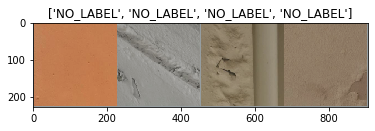

In [14]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.588, 0.618, 0.630])
    std = np.array([0.092, 0.086, 0.086])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated



class_names = dataset.classes
print(class_names)
# Get a batch of training data
inputs, classes = next(iter(train_loader))
inputs2 = inputs [1]
inputs3 = inputs2 [:4]
classes2 = classes[:4]+1

# # Make a grid from batch
out = torchvision.utils.make_grid(inputs3)
imshow(out, title=[class_names[x] for x in classes2])

## Create model

In [15]:
def create_model(ema=False):
        
    model = models.resnet101(pretrained=True)
    num_rs = model.fc1.in_features
    model.fc1 = nn.Linear(num_rs, num_classes)
    num_rs = model.fc2.in_features
    model.fc2 = nn.Linear(num_rs, num_classes)    
    model = nn.DataParallel(model).to(device)
                 


    if ema:
        for param in model.parameters():
            param.detach_()  # separate the parameters from the model to not participate the param update
            # teacher model does not require gradient descent

    return model

model = create_model()
ema_model = create_model(ema=True)


LOG.info(parameters_string(model))


List of model parameters:
module.conv1.weight                            64 * 3 * 7 * 7 =       9,408
module.bn1.weight                                          64 =          64
module.bn1.bias                                            64 =          64
module.layer1.0.conv1.weight                  64 * 64 * 1 * 1 =       4,096
module.layer1.0.bn1.weight                                 64 =          64
module.layer1.0.bn1.bias                                   64 =          64
module.layer1.0.conv2.weight                  64 * 64 * 3 * 3 =      36,864
module.layer1.0.bn2.weight                                 64 =          64
module.layer1.0.bn2.bias                                   64 =          64
module.layer1.0.conv3.weight                 256 * 64 * 1 * 1 =      16,384
module.layer1.0.bn3.weight                                256 =         256
module.layer1.0.bn3.bias                                  256 =         256
module.layer1.0.downsample.0.weight          256 * 64 * 1 * 1

## Train & Test

In [16]:
optimizer = torch.optim.SGD(model.parameters(), args.lr,
                            momentum=args.momentum,
                            weight_decay=args.weight_decay,
                            nesterov=args.nesterov)

# optionally resume from a checkpoint


cudnn.benchmark = True

if args.evaluate:
    LOG.info("Evaluating the primary model:")
    validate(eval_loader, model, validation_log, global_step, args.start_epoch)
    LOG.info("Evaluating the EMA model:")
    validate(eval_loader, ema_model, ema_validation_log, global_step, args.start_epoch)
    
since = time.time()
for epoch in range(args.start_epoch, args.epochs):
    print('Epoch {}/{}'.format(epoch, args.epochs - 1))
    print('-' * 10)    
    
    start_time = time.time()
    # train for one epoch
    epoch_acc_unc, epoch_acc_all = train(train_loader, model, ema_model, optimizer, epoch)
    LOG.info("--- training epoch in %s seconds ---" % (time.time() - start_time))
    viz.line([[epoch_acc_unc,epoch_acc_all]], [epoch], win = 'Train_acc', update = 'append')

    if args.evaluation_epochs and (epoch + 1) % args.evaluation_epochs == 0:
        start_time = time.time()
        LOG.info("Evaluating the primary model:")
        prec1 = validate(eval_loader, model, validation_log, global_step, epoch + 1)
        LOG.info("Evaluating the EMA model:")
        ema_prec1 = validate(eval_loader, ema_model, ema_validation_log, global_step, epoch + 1)
        LOG.info("--- validation in %s seconds ---" % (time.time() - start_time))
        is_best = ema_prec1 > best_prec1
        best_prec1 = max(ema_prec1, best_prec1)
        
        viz.line([[prec1.cpu().numpy(),ema_prec1.cpu().numpy()]], [epoch], win = 'Test_acc', update = 'append')
        
    else:
        is_best = False

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
time_elapsed // 60, time_elapsed % 60))


Epoch 0/39
----------
tensor(0.)
tensor(500.)
3
tensor(100.)
tensor(800.)
6
tensor(300.)
tensor(1500.)
9
tensor(400.)
tensor(1700.)
12
tensor(400.)
tensor(2100.)
15
tensor(500.)
tensor(2600.)
18
tensor(500.)
tensor(2800.)
21
tensor(600.)
tensor(3500.)
24
tensor(600.)
tensor(4400.)
27
tensor(600.)
tensor(5400.)
30
tensor(600.)
tensor(6300.)
33
tensor(700.)
tensor(7200.)
36
tensor(700.)
tensor(8100.)
39
tensor(700.)
tensor(9400.)
42
tensor(700.)
tensor(10500.)
45
tensor(700.)
tensor(11400.)
48
tensor(700.)
tensor(12800.)
51
tensor(700.)
tensor(14000.)
54
tensor(700.)
tensor(14900.)
57
tensor(700.)
tensor(16700.)
60
tensor(700.)
tensor(18400.)
63
tensor(700.)
tensor(20000.)
66
tensor(700.)
tensor(22100.)
69
tensor(700.)
tensor(24100.)
72
tensor(700.)
tensor(26500.)
75
tensor(700.)
tensor(28700.)
78
tensor(700.)
tensor(30100.)
81
tensor(700.)
tensor(32000.)
84
tensor(700.)
tensor(33400.)
87
tensor(700.)
tensor(35700.)
90
tensor(700.)
tensor(37600.)
93
tensor(700.)
tensor(39600.)
96
tensor(

--- training epoch in 117.31520557403564 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 78.61445617675781


--- validation in 5.640639543533325 seconds ---


test acc: 75.80320739746094
Epoch 1/39
----------
tensor(0.)
tensor(3200.)
6
tensor(200.)
tensor(6400.)
12
tensor(200.)
tensor(9600.)
18
tensor(200.)
tensor(12800.)
24
tensor(200.)
tensor(16000.)
30
tensor(200.)
tensor(19200.)
36
tensor(200.)
tensor(22400.)
42
tensor(200.)
tensor(25600.)
48
tensor(200.)
tensor(28800.)
54
tensor(200.)
tensor(32000.)
60
tensor(200.)
tensor(35200.)
66
tensor(200.)
tensor(38400.)
72
tensor(200.)
tensor(41600.)
78
tensor(300.)
tensor(44800.)
84
tensor(300.)
tensor(48000.)
90
tensor(300.)
tensor(51200.)
96
tensor(300.)
tensor(54400.)
102
tensor(300.)
tensor(57600.)
108
tensor(300.)
tensor(60800.)
114
tensor(400.)
tensor(64000.)
120
tensor(400.)
tensor(67200.)
126
tensor(400.)
tensor(70400.)
132
tensor(500.)
tensor(73600.)
138
tensor(500.)
tensor(76800.)
144
tensor(500.)
tensor(80000.)
150
tensor(500.)
tensor(83200.)
156
tensor(600.)
tensor(86400.)
162
tensor(600.)
tensor(89600.)
168
tensor(600.)
tensor(92800.)
174
tensor(600.)
tensor(96000.)
180
tensor(600.)

--- training epoch in 115.02458715438843 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 79.31726837158203


--- validation in 5.044774532318115 seconds ---


test acc: 77.9116439819336
Epoch 2/39
----------
tensor(200.)
tensor(3200.)
9
tensor(300.)
tensor(6400.)
18
tensor(400.)
tensor(9600.)
27
tensor(400.)
tensor(12800.)
36
tensor(400.)
tensor(16000.)
45
tensor(500.)
tensor(19200.)
54
tensor(700.)
tensor(22400.)
63
tensor(700.)
tensor(25600.)
72
tensor(800.)
tensor(28800.)
81
tensor(800.)
tensor(32000.)
90
tensor(800.)
tensor(35200.)
99
tensor(800.)
tensor(38400.)
108
tensor(900.)
tensor(41600.)
117
tensor(1000.)
tensor(44800.)
126
tensor(1200.)
tensor(48000.)
135
tensor(1200.)
tensor(51200.)
144
tensor(1200.)
tensor(54400.)
153
tensor(1200.)
tensor(57600.)
162
tensor(1200.)
tensor(60800.)
171
tensor(1300.)
tensor(64000.)
180
tensor(1300.)
tensor(67200.)
189
tensor(1400.)
tensor(70400.)
198
tensor(1400.)
tensor(73600.)
207
tensor(1400.)
tensor(76800.)
216
tensor(1500.)
tensor(80000.)
225
tensor(1600.)
tensor(83200.)
234
tensor(1600.)
tensor(86400.)
243
tensor(1600.)
tensor(89600.)
252
tensor(1700.)
tensor(92800.)
261
tensor(1700.)
tensor(9

--- training epoch in 115.17921018600464 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 80.12047576904297


--- validation in 5.021653652191162 seconds ---


test acc: 78.91565704345703
Epoch 3/39
----------
tensor(0.)
tensor(3200.)
12
tensor(100.)
tensor(6400.)
24
tensor(200.)
tensor(9600.)
36
tensor(300.)
tensor(12800.)
48
tensor(500.)
tensor(16000.)
60
tensor(600.)
tensor(19200.)
72
tensor(700.)
tensor(22400.)
84
tensor(800.)
tensor(25600.)
96
tensor(800.)
tensor(28800.)
108
tensor(900.)
tensor(32000.)
120
tensor(900.)
tensor(35200.)
132
tensor(900.)
tensor(38400.)
144
tensor(1100.)
tensor(41600.)
156
tensor(1200.)
tensor(44800.)
168
tensor(1300.)
tensor(48000.)
180
tensor(1500.)
tensor(51200.)
192
tensor(1600.)
tensor(54400.)
204
tensor(1800.)
tensor(57600.)
216
tensor(1900.)
tensor(60800.)
228
tensor(2000.)
tensor(64000.)
240
tensor(2100.)
tensor(67200.)
252
tensor(2200.)
tensor(70400.)
264
tensor(2300.)
tensor(73600.)
276
tensor(2500.)
tensor(76800.)
288
tensor(2600.)
tensor(80000.)
300
tensor(2700.)
tensor(83200.)
312
tensor(2800.)
tensor(86400.)
324
tensor(2900.)
tensor(89600.)
336
tensor(3100.)
tensor(92800.)
348
tensor(3300.)
tens

--- training epoch in 116.01798391342163 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 80.32128143310547


--- validation in 5.190250635147095 seconds ---


test acc: 78.21284484863281
Epoch 4/39
----------
tensor(0.)
tensor(3200.)
15
tensor(100.)
tensor(6400.)
30
tensor(300.)
tensor(9600.)
45
tensor(600.)
tensor(12800.)
60
tensor(800.)
tensor(16000.)
75
tensor(1000.)
tensor(19200.)
90
tensor(1200.)
tensor(22400.)
105
tensor(1400.)
tensor(25600.)
120
tensor(1500.)
tensor(28800.)
135
tensor(1800.)
tensor(32000.)
150
tensor(2100.)
tensor(35200.)
165
tensor(2200.)
tensor(38400.)
180
tensor(2400.)
tensor(41600.)
195
tensor(2600.)
tensor(44800.)
210
tensor(2700.)
tensor(48000.)
225
tensor(2900.)
tensor(51200.)
240
tensor(3100.)
tensor(54400.)
255
tensor(3200.)
tensor(57600.)
270
tensor(3400.)
tensor(60800.)
285
tensor(3400.)
tensor(64000.)
300
tensor(3600.)
tensor(67200.)
315
tensor(3800.)
tensor(70400.)
330
tensor(4100.)
tensor(73600.)
345
tensor(4200.)
tensor(76800.)
360
tensor(4400.)
tensor(80000.)
375
tensor(4500.)
tensor(83200.)
390
tensor(4700.)
tensor(86400.)
405
tensor(4700.)
tensor(89600.)
420
tensor(4800.)
tensor(92800.)
435
tensor(49

--- training epoch in 115.81582689285278 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 80.82328796386719


--- validation in 5.047544717788696 seconds ---


test acc: 78.91565704345703
Epoch 5/39
----------
tensor(100.)
tensor(3200.)
18
tensor(300.)
tensor(6400.)
36
tensor(700.)
tensor(9600.)
54
tensor(900.)
tensor(12800.)
72
tensor(1100.)
tensor(16000.)
90
tensor(1200.)
tensor(19200.)
108
tensor(1300.)
tensor(22400.)
126
tensor(1500.)
tensor(25600.)
144
tensor(1700.)
tensor(28800.)
162
tensor(1900.)
tensor(32000.)
180
tensor(1900.)
tensor(35200.)
198
tensor(2100.)
tensor(38400.)
216
tensor(2300.)
tensor(41600.)
234
tensor(2400.)
tensor(44800.)
252
tensor(2700.)
tensor(48000.)
270
tensor(2800.)
tensor(51200.)
288
tensor(3000.)
tensor(54400.)
306
tensor(3200.)
tensor(57600.)
324
tensor(3500.)
tensor(60800.)
342
tensor(3600.)
tensor(64000.)
360
tensor(3900.)
tensor(67200.)
378
tensor(4000.)
tensor(70400.)
396
tensor(4400.)
tensor(73600.)
414
tensor(4600.)
tensor(76800.)
432
tensor(4800.)
tensor(80000.)
450
tensor(4900.)
tensor(83200.)
468
tensor(5000.)
tensor(86400.)
486
tensor(5100.)
tensor(89600.)
504
tensor(5200.)
tensor(92800.)
522
tenso

--- training epoch in 115.8231451511383 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 81.02409362792969


--- validation in 4.962202787399292 seconds ---


test acc: 79.01605987548828
Epoch 6/39
----------
tensor(100.)
tensor(3200.)
21
tensor(400.)
tensor(6400.)
42
tensor(600.)
tensor(9600.)
63
tensor(800.)
tensor(12800.)
84
tensor(1200.)
tensor(16000.)
105
tensor(1500.)
tensor(19200.)
126
tensor(1600.)
tensor(22400.)
147
tensor(1700.)
tensor(25600.)
168
tensor(1900.)
tensor(28800.)
189
tensor(2200.)
tensor(32000.)
210
tensor(2400.)
tensor(35200.)
231
tensor(2800.)
tensor(38400.)
252
tensor(3000.)
tensor(41600.)
273
tensor(3300.)
tensor(44800.)
294
tensor(3500.)
tensor(48000.)
315
tensor(3700.)
tensor(51200.)
336
tensor(4000.)
tensor(54400.)
357
tensor(4300.)
tensor(57600.)
378
tensor(4600.)
tensor(60800.)
399
tensor(4800.)
tensor(64000.)
420
tensor(5000.)
tensor(67200.)
441
tensor(5100.)
tensor(70400.)
462
tensor(5400.)
tensor(73600.)
483
tensor(5700.)
tensor(76800.)
504
tensor(5900.)
tensor(80000.)
525
tensor(6200.)
tensor(83200.)
546
tensor(6400.)
tensor(86400.)
567
tensor(6600.)
tensor(89600.)
588
tensor(6900.)
tensor(92800.)
609
tens

--- training epoch in 116.16548347473145 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 80.22087860107422


--- validation in 4.906531810760498 seconds ---


test acc: 78.81526184082031
Epoch 7/39
----------
tensor(200.)
tensor(3200.)
24
tensor(400.)
tensor(6400.)
48
tensor(800.)
tensor(9600.)
72
tensor(1100.)
tensor(12800.)
96
tensor(1400.)
tensor(16000.)
120
tensor(1800.)
tensor(19200.)
144
tensor(1900.)
tensor(22400.)
168
tensor(2400.)
tensor(25600.)
192
tensor(2500.)
tensor(28800.)
216
tensor(2800.)
tensor(32000.)
240
tensor(3100.)
tensor(35200.)
264
tensor(3300.)
tensor(38400.)
288
tensor(3500.)
tensor(41600.)
312
tensor(3900.)
tensor(44800.)
336
tensor(4100.)
tensor(48000.)
360
tensor(4300.)
tensor(51200.)
384
tensor(4700.)
tensor(54400.)
408
tensor(5000.)
tensor(57600.)
432
tensor(5300.)
tensor(60800.)
456
tensor(5700.)
tensor(64000.)
480
tensor(6400.)
tensor(67200.)
504
tensor(6600.)
tensor(70400.)
528
tensor(6800.)
tensor(73600.)
552
tensor(7000.)
tensor(76800.)
576
tensor(7300.)
tensor(80000.)
600
tensor(7600.)
tensor(83200.)
624
tensor(8100.)
tensor(86400.)
648
tensor(8400.)
tensor(89600.)
672
tensor(8600.)
tensor(92800.)
696
ten

--- training epoch in 115.63500237464905 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 81.02409362792969


--- validation in 5.054150342941284 seconds ---


test acc: 79.7188720703125
Epoch 8/39
----------
tensor(300.)
tensor(3200.)
27
tensor(700.)
tensor(6400.)
54
tensor(1000.)
tensor(9600.)
81
tensor(1000.)
tensor(12800.)
108
tensor(1500.)
tensor(16000.)
135
tensor(1600.)
tensor(19200.)
162
tensor(2100.)
tensor(22400.)
189
tensor(2600.)
tensor(25600.)
216
tensor(3100.)
tensor(28800.)
243
tensor(3300.)
tensor(32000.)
270
tensor(3600.)
tensor(35200.)
297
tensor(4100.)
tensor(38400.)
324
tensor(4300.)
tensor(41600.)
351
tensor(4700.)
tensor(44800.)
378
tensor(5100.)
tensor(48000.)
405
tensor(5300.)
tensor(51200.)
432
tensor(5600.)
tensor(54400.)
459
tensor(5900.)
tensor(57600.)
486
tensor(6400.)
tensor(60800.)
513
tensor(6800.)
tensor(64000.)
540
tensor(7000.)
tensor(67200.)
567
tensor(7300.)
tensor(70400.)
594
tensor(7500.)
tensor(73600.)
621
tensor(7900.)
tensor(76800.)
648
tensor(8300.)
tensor(80000.)
675
tensor(8800.)
tensor(83200.)
702
tensor(9000.)
tensor(86400.)
729
tensor(9400.)
tensor(89600.)
756
tensor(9600.)
tensor(92800.)
783
te

--- training epoch in 115.67014169692993 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 81.22489929199219


--- validation in 5.332547903060913 seconds ---


test acc: 79.919677734375
Epoch 9/39
----------
tensor(400.)
tensor(3200.)
30
tensor(1000.)
tensor(6400.)
60
tensor(1400.)
tensor(9600.)
90
tensor(1600.)
tensor(12800.)
120
tensor(2000.)
tensor(16000.)
150
tensor(2400.)
tensor(19200.)
180
tensor(2500.)
tensor(22400.)
210
tensor(2800.)
tensor(25600.)
240
tensor(3400.)
tensor(28800.)
270
tensor(3900.)
tensor(32000.)
300
tensor(4400.)
tensor(35200.)
330
tensor(4600.)
tensor(38400.)
360
tensor(4900.)
tensor(41600.)
390
tensor(5200.)
tensor(44800.)
420
tensor(5600.)
tensor(48000.)
450
tensor(6000.)
tensor(51200.)
480
tensor(6600.)
tensor(54400.)
510
tensor(6900.)
tensor(57600.)
540
tensor(7500.)
tensor(60800.)
570
tensor(7800.)
tensor(64000.)
600
tensor(8300.)
tensor(67200.)
630
tensor(8800.)
tensor(70400.)
660
tensor(9000.)
tensor(73600.)
690
tensor(9200.)
tensor(76800.)
720
tensor(9700.)
tensor(80000.)
750
tensor(10200.)
tensor(83200.)
780
tensor(10700.)
tensor(86400.)
810
tensor(11000.)
tensor(89600.)
840
tensor(11600.)
tensor(92800.)
87

--- training epoch in 115.01440191268921 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 80.42168426513672


--- validation in 5.032315731048584 seconds ---


test acc: 80.22087860107422
Epoch 10/39
----------
tensor(400.)
tensor(3200.)
33
tensor(600.)
tensor(6400.)
66
tensor(1100.)
tensor(9600.)
99
tensor(1600.)
tensor(12800.)
132
tensor(1900.)
tensor(16000.)
165
tensor(2400.)
tensor(19200.)
198
tensor(3100.)
tensor(22400.)
231
tensor(3500.)
tensor(25600.)
264
tensor(3900.)
tensor(28800.)
297
tensor(4400.)
tensor(32000.)
330
tensor(5000.)
tensor(35200.)
363
tensor(5400.)
tensor(38400.)
396
tensor(5700.)
tensor(41600.)
429
tensor(6000.)
tensor(44800.)
462
tensor(6700.)
tensor(48000.)
495
tensor(7100.)
tensor(51200.)
528
tensor(7700.)
tensor(54400.)
561
tensor(8200.)
tensor(57600.)
594
tensor(8700.)
tensor(60800.)
627
tensor(9200.)
tensor(64000.)
660
tensor(9600.)
tensor(67200.)
693
tensor(9900.)
tensor(70400.)
726
tensor(10500.)
tensor(73600.)
759
tensor(10900.)
tensor(76800.)
792
tensor(11500.)
tensor(80000.)
825
tensor(11800.)
tensor(83200.)
858
tensor(12100.)
tensor(86400.)
891
tensor(12600.)
tensor(89600.)
924
tensor(13100.)
tensor(92800

--- training epoch in 115.64655709266663 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 81.22489929199219


--- validation in 5.084246397018433 seconds ---


test acc: 80.12047576904297
Epoch 11/39
----------
tensor(200.)
tensor(3200.)
36
tensor(700.)
tensor(6400.)
72
tensor(1300.)
tensor(9600.)
108
tensor(1500.)
tensor(12800.)
144
tensor(2000.)
tensor(16000.)
180
tensor(2500.)
tensor(19200.)
216
tensor(2900.)
tensor(22400.)
252
tensor(3200.)
tensor(25600.)
288
tensor(3900.)
tensor(28800.)
324
tensor(4400.)
tensor(32000.)
360
tensor(4900.)
tensor(35200.)
396
tensor(5600.)
tensor(38400.)
432
tensor(5800.)
tensor(41600.)
468
tensor(6700.)
tensor(44800.)
504
tensor(6900.)
tensor(48000.)
540
tensor(7400.)
tensor(51200.)
576
tensor(8000.)
tensor(54400.)
612
tensor(8300.)
tensor(57600.)
648
tensor(8500.)
tensor(60800.)
684
tensor(8800.)
tensor(64000.)
720
tensor(9500.)
tensor(67200.)
756
tensor(9900.)
tensor(70400.)
792
tensor(10400.)
tensor(73600.)
828
tensor(11000.)
tensor(76800.)
864
tensor(11400.)
tensor(80000.)
900
tensor(11800.)
tensor(83200.)
936
tensor(12200.)
tensor(86400.)
972
tensor(12700.)
tensor(89600.)
1008
tensor(13100.)
tensor(928

--- training epoch in 115.06999135017395 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 80.32128143310547


--- validation in 5.195109844207764 seconds ---


test acc: 80.22087860107422
Epoch 12/39
----------
tensor(400.)
tensor(3200.)
39
tensor(1000.)
tensor(6400.)
78
tensor(1400.)
tensor(9600.)
117
tensor(1900.)
tensor(12800.)
156
tensor(2400.)
tensor(16000.)
195
tensor(2900.)
tensor(19200.)
234
tensor(3400.)
tensor(22400.)
273
tensor(3500.)
tensor(25600.)
312
tensor(3800.)
tensor(28800.)
351
tensor(4500.)
tensor(32000.)
390
tensor(5100.)
tensor(35200.)
429
tensor(5400.)
tensor(38400.)
468
tensor(5800.)
tensor(41600.)
507
tensor(6300.)
tensor(44800.)
546
tensor(6900.)
tensor(48000.)
585
tensor(7300.)
tensor(51200.)
624
tensor(7600.)
tensor(54400.)
663
tensor(8100.)
tensor(57600.)
702
tensor(8400.)
tensor(60800.)
741
tensor(8600.)
tensor(64000.)
780
tensor(9300.)
tensor(67200.)
819
tensor(10000.)
tensor(70400.)
858
tensor(10300.)
tensor(73600.)
897
tensor(11000.)
tensor(76800.)
936
tensor(11600.)
tensor(80000.)
975
tensor(12000.)
tensor(83200.)
1014
tensor(12700.)
tensor(86400.)
1053
tensor(13000.)
tensor(89600.)
1092
tensor(13300.)
tensor

--- training epoch in 115.08233523368835 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 80.82328796386719


--- validation in 5.111716985702515 seconds ---


test acc: 80.02008056640625
Epoch 13/39
----------
tensor(600.)
tensor(3200.)
42
tensor(1000.)
tensor(6400.)
84
tensor(1600.)
tensor(9600.)
126
tensor(2400.)
tensor(12800.)
168
tensor(3000.)
tensor(16000.)
210
tensor(3300.)
tensor(19200.)
252
tensor(3700.)
tensor(22400.)
294
tensor(4000.)
tensor(25600.)
336
tensor(4200.)
tensor(28800.)
378
tensor(4700.)
tensor(32000.)
420
tensor(5000.)
tensor(35200.)
462
tensor(5700.)
tensor(38400.)
504
tensor(5900.)
tensor(41600.)
546
tensor(6200.)
tensor(44800.)
588
tensor(6700.)
tensor(48000.)
630
tensor(7400.)
tensor(51200.)
672
tensor(7800.)
tensor(54400.)
714
tensor(8500.)
tensor(57600.)
756
tensor(8700.)
tensor(60800.)
798
tensor(8800.)
tensor(64000.)
840
tensor(9400.)
tensor(67200.)
882
tensor(10100.)
tensor(70400.)
924
tensor(10200.)
tensor(73600.)
966
tensor(10500.)
tensor(76800.)
1008
tensor(11400.)
tensor(80000.)
1050
tensor(11900.)
tensor(83200.)
1092
tensor(12400.)
tensor(86400.)
1134
tensor(12800.)
tensor(89600.)
1176
tensor(13200.)
tens

--- training epoch in 115.07982516288757 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 80.22087860107422


--- validation in 4.983447074890137 seconds ---


test acc: 80.42168426513672
Epoch 14/39
----------
tensor(400.)
tensor(3200.)
45
tensor(1200.)
tensor(6400.)
90
tensor(1500.)
tensor(9600.)
135
tensor(1900.)
tensor(12800.)
180
tensor(2500.)
tensor(16000.)
225
tensor(3000.)
tensor(19200.)
270
tensor(3500.)
tensor(22400.)
315
tensor(3700.)
tensor(25600.)
360
tensor(3900.)
tensor(28800.)
405
tensor(4500.)
tensor(32000.)
450
tensor(5000.)
tensor(35200.)
495
tensor(5500.)
tensor(38400.)
540
tensor(6000.)
tensor(41600.)
585
tensor(6100.)
tensor(44800.)
630
tensor(6600.)
tensor(48000.)
675
tensor(7600.)
tensor(51200.)
720
tensor(8000.)
tensor(54400.)
765
tensor(8200.)
tensor(57600.)
810
tensor(8700.)
tensor(60800.)
855
tensor(9100.)
tensor(64000.)
900
tensor(9700.)
tensor(67200.)
945
tensor(10000.)
tensor(70400.)
990
tensor(10500.)
tensor(73600.)
1035
tensor(10700.)
tensor(76800.)
1080
tensor(11300.)
tensor(80000.)
1125
tensor(11800.)
tensor(83200.)
1170
tensor(12000.)
tensor(86400.)
1215
tensor(12400.)
tensor(89600.)
1260
tensor(12700.)
ten

--- training epoch in 115.12141394615173 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 82.42971801757812


--- validation in 4.894178628921509 seconds ---


test acc: 80.52208709716797
Epoch 15/39
----------
tensor(600.)
tensor(3200.)
48
tensor(1100.)
tensor(6400.)
96
tensor(1600.)
tensor(9600.)
144
tensor(2000.)
tensor(12800.)
192
tensor(2700.)
tensor(16000.)
240
tensor(2900.)
tensor(19200.)
288
tensor(3300.)
tensor(22400.)
336
tensor(3900.)
tensor(25600.)
384
tensor(4400.)
tensor(28800.)
432
tensor(4800.)
tensor(32000.)
480
tensor(5000.)
tensor(35200.)
528
tensor(5200.)
tensor(38400.)
576
tensor(5700.)
tensor(41600.)
624
tensor(6400.)
tensor(44800.)
672
tensor(6800.)
tensor(48000.)
720
tensor(7300.)
tensor(51200.)
768
tensor(7700.)
tensor(54400.)
816
tensor(8200.)
tensor(57600.)
864
tensor(8600.)
tensor(60800.)
912
tensor(9000.)
tensor(64000.)
960
tensor(9500.)
tensor(67200.)
1008
tensor(10100.)
tensor(70400.)
1056
tensor(10500.)
tensor(73600.)
1104
tensor(10800.)
tensor(76800.)
1152
tensor(11200.)
tensor(80000.)
1200
tensor(11800.)
tensor(83200.)
1248
tensor(12800.)
tensor(86400.)
1296
tensor(13100.)
tensor(89600.)
1344
tensor(13500.)
t

--- training epoch in 114.79510188102722 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 82.02810668945312


--- validation in 5.04308557510376 seconds ---


test acc: 81.3252944946289
Epoch 16/39
----------
tensor(300.)
tensor(3200.)
51
tensor(400.)
tensor(6400.)
102
tensor(900.)
tensor(9600.)
153
tensor(1300.)
tensor(12800.)
204
tensor(1700.)
tensor(16000.)
255
tensor(2500.)
tensor(19200.)
306
tensor(2800.)
tensor(22400.)
357
tensor(3400.)
tensor(25600.)
408
tensor(3700.)
tensor(28800.)
459
tensor(4400.)
tensor(32000.)
510
tensor(5000.)
tensor(35200.)
561
tensor(5400.)
tensor(38400.)
612
tensor(6000.)
tensor(41600.)
663
tensor(6400.)
tensor(44800.)
714
tensor(7000.)
tensor(48000.)
765
tensor(7200.)
tensor(51200.)
816
tensor(7700.)
tensor(54400.)
867
tensor(8300.)
tensor(57600.)
918
tensor(8800.)
tensor(60800.)
969
tensor(9200.)
tensor(64000.)
1020
tensor(9500.)
tensor(67200.)
1071
tensor(10000.)
tensor(70400.)
1122
tensor(10300.)
tensor(73600.)
1173
tensor(11100.)
tensor(76800.)
1224
tensor(11700.)
tensor(80000.)
1275
tensor(12100.)
tensor(83200.)
1326
tensor(12400.)
tensor(86400.)
1377
tensor(13000.)
tensor(89600.)
1428
tensor(13500.)
te

--- training epoch in 114.80427289009094 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 81.12449645996094


--- validation in 4.983598232269287 seconds ---


test acc: 81.7269058227539
Epoch 17/39
----------
tensor(300.)
tensor(3200.)
54
tensor(600.)
tensor(6400.)
108
tensor(800.)
tensor(9600.)
162
tensor(1600.)
tensor(12800.)
216
tensor(2000.)
tensor(16000.)
270
tensor(2400.)
tensor(19200.)
324
tensor(3000.)
tensor(22400.)
378
tensor(3300.)
tensor(25600.)
432
tensor(3800.)
tensor(28800.)
486
tensor(4300.)
tensor(32000.)
540
tensor(5000.)
tensor(35200.)
594
tensor(5400.)
tensor(38400.)
648
tensor(6100.)
tensor(41600.)
702
tensor(6500.)
tensor(44800.)
756
tensor(6700.)
tensor(48000.)
810
tensor(6900.)
tensor(51200.)
864
tensor(7500.)
tensor(54400.)
918
tensor(8000.)
tensor(57600.)
972
tensor(8200.)
tensor(60800.)
1026
tensor(9000.)
tensor(64000.)
1080
tensor(9300.)
tensor(67200.)
1134
tensor(10200.)
tensor(70400.)
1188
tensor(10800.)
tensor(73600.)
1242
tensor(11200.)
tensor(76800.)
1296
tensor(11700.)
tensor(80000.)
1350
tensor(12000.)
tensor(83200.)
1404
tensor(12300.)
tensor(86400.)
1458
tensor(12900.)
tensor(89600.)
1512
tensor(13300.)
t

--- training epoch in 114.70330834388733 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 82.02810668945312


--- validation in 5.123428106307983 seconds ---


test acc: 81.12449645996094
Epoch 18/39
----------
tensor(500.)
tensor(3200.)
57
tensor(800.)
tensor(6400.)
114
tensor(1400.)
tensor(9600.)
171
tensor(1700.)
tensor(12800.)
228
tensor(2200.)
tensor(16000.)
285
tensor(2700.)
tensor(19200.)
342
tensor(3000.)
tensor(22400.)
399
tensor(3600.)
tensor(25600.)
456
tensor(3800.)
tensor(28800.)
513
tensor(4500.)
tensor(32000.)
570
tensor(5000.)
tensor(35200.)
627
tensor(5200.)
tensor(38400.)
684
tensor(5600.)
tensor(41600.)
741
tensor(6200.)
tensor(44800.)
798
tensor(6700.)
tensor(48000.)
855
tensor(7000.)
tensor(51200.)
912
tensor(7600.)
tensor(54400.)
969
tensor(8000.)
tensor(57600.)
1026
tensor(8700.)
tensor(60800.)
1083
tensor(9500.)
tensor(64000.)
1140
tensor(9900.)
tensor(67200.)
1197
tensor(10000.)
tensor(70400.)
1254
tensor(10600.)
tensor(73600.)
1311
tensor(10900.)
tensor(76800.)
1368
tensor(11700.)
tensor(80000.)
1425
tensor(12100.)
tensor(83200.)
1482
tensor(12800.)
tensor(86400.)
1539
tensor(13200.)
tensor(89600.)
1596
tensor(13500.

--- training epoch in 114.55965042114258 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 80.62248992919922


--- validation in 4.8693201541900635 seconds ---


test acc: 81.42569732666016
Epoch 19/39
----------
tensor(800.)
tensor(3200.)
60
tensor(1400.)
tensor(6400.)
120
tensor(1900.)
tensor(9600.)
180
tensor(2400.)
tensor(12800.)
240
tensor(2600.)
tensor(16000.)
300
tensor(3100.)
tensor(19200.)
360
tensor(3900.)
tensor(22400.)
420
tensor(4300.)
tensor(25600.)
480
tensor(4500.)
tensor(28800.)
540
tensor(4900.)
tensor(32000.)
600
tensor(5100.)
tensor(35200.)
660
tensor(5500.)
tensor(38400.)
720
tensor(5900.)
tensor(41600.)
780
tensor(6300.)
tensor(44800.)
840
tensor(6800.)
tensor(48000.)
900
tensor(7000.)
tensor(51200.)
960
tensor(7200.)
tensor(54400.)
1020
tensor(7500.)
tensor(57600.)
1080
tensor(8400.)
tensor(60800.)
1140
tensor(8900.)
tensor(64000.)
1200
tensor(9600.)
tensor(67200.)
1260
tensor(10000.)
tensor(70400.)
1320
tensor(10700.)
tensor(73600.)
1380
tensor(11300.)
tensor(76800.)
1440
tensor(11500.)
tensor(80000.)
1500
tensor(12200.)
tensor(83200.)
1560
tensor(12800.)
tensor(86400.)
1620
tensor(13400.)
tensor(89600.)
1680
tensor(1380

--- training epoch in 114.48202180862427 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 81.42569732666016


--- validation in 4.90280556678772 seconds ---


test acc: 81.12449645996094
Epoch 20/39
----------
tensor(500.)
tensor(3200.)
63
tensor(700.)
tensor(6400.)
126
tensor(1100.)
tensor(9600.)
189
tensor(1400.)
tensor(12800.)
252
tensor(1700.)
tensor(16000.)
315
tensor(2200.)
tensor(19200.)
378
tensor(2800.)
tensor(22400.)
441
tensor(2900.)
tensor(25600.)
504
tensor(3900.)
tensor(28800.)
567
tensor(4500.)
tensor(32000.)
630
tensor(5100.)
tensor(35200.)
693
tensor(5400.)
tensor(38400.)
756
tensor(5900.)
tensor(41600.)
819
tensor(6600.)
tensor(44800.)
882
tensor(7100.)
tensor(48000.)
945
tensor(8000.)
tensor(51200.)
1008
tensor(8300.)
tensor(54400.)
1071
tensor(8400.)
tensor(57600.)
1134
tensor(8900.)
tensor(60800.)
1197
tensor(9300.)
tensor(64000.)
1260
tensor(9500.)
tensor(67200.)
1323
tensor(10100.)
tensor(70400.)
1386
tensor(10500.)
tensor(73600.)
1449
tensor(11000.)
tensor(76800.)
1512
tensor(11400.)
tensor(80000.)
1575
tensor(11800.)
tensor(83200.)
1638
tensor(12500.)
tensor(86400.)
1701
tensor(12700.)
tensor(89600.)
1764
tensor(1300

--- training epoch in 114.33732056617737 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 81.9277114868164


--- validation in 4.939807891845703 seconds ---


test acc: 81.3252944946289
Epoch 21/39
----------
tensor(500.)
tensor(3200.)
64
tensor(700.)
tensor(6400.)
128
tensor(1200.)
tensor(9600.)
192
tensor(1500.)
tensor(12800.)
256
tensor(2300.)
tensor(16000.)
320
tensor(2800.)
tensor(19200.)
384
tensor(3200.)
tensor(22400.)
448
tensor(3800.)
tensor(25600.)
512
tensor(4200.)
tensor(28800.)
576
tensor(4500.)
tensor(32000.)
640
tensor(5000.)
tensor(35200.)
704
tensor(6000.)
tensor(38400.)
768
tensor(6200.)
tensor(41600.)
832
tensor(6400.)
tensor(44800.)
896
tensor(6900.)
tensor(48000.)
960
tensor(7100.)
tensor(51200.)
1024
tensor(7600.)
tensor(54400.)
1088
tensor(8100.)
tensor(57600.)
1152
tensor(8700.)
tensor(60800.)
1216
tensor(9000.)
tensor(64000.)
1280
tensor(9800.)
tensor(67200.)
1344
tensor(10100.)
tensor(70400.)
1408
tensor(10600.)
tensor(73600.)
1472
tensor(11000.)
tensor(76800.)
1536
tensor(11700.)
tensor(80000.)
1600
tensor(12000.)
tensor(83200.)
1664
tensor(12700.)
tensor(86400.)
1728
tensor(13500.)
tensor(89600.)
1792
tensor(13500

--- training epoch in 114.85089802742004 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 80.52208709716797


--- validation in 4.893808603286743 seconds ---


test acc: 81.7269058227539
Epoch 22/39
----------
tensor(400.)
tensor(3200.)
64
tensor(1200.)
tensor(6400.)
128
tensor(1600.)
tensor(9600.)
192
tensor(2300.)
tensor(12800.)
256
tensor(2600.)
tensor(16000.)
320
tensor(2900.)
tensor(19200.)
384
tensor(3200.)
tensor(22400.)
448
tensor(3500.)
tensor(25600.)
512
tensor(4100.)
tensor(28800.)
576
tensor(4600.)
tensor(32000.)
640
tensor(5000.)
tensor(35200.)
704
tensor(5400.)
tensor(38400.)
768
tensor(5900.)
tensor(41600.)
832
tensor(6100.)
tensor(44800.)
896
tensor(6400.)
tensor(48000.)
960
tensor(7200.)
tensor(51200.)
1024
tensor(7600.)
tensor(54400.)
1088
tensor(8100.)
tensor(57600.)
1152
tensor(8400.)
tensor(60800.)
1216
tensor(8900.)
tensor(64000.)
1280
tensor(9500.)
tensor(67200.)
1344
tensor(10100.)
tensor(70400.)
1408
tensor(10300.)
tensor(73600.)
1472
tensor(10600.)
tensor(76800.)
1536
tensor(10900.)
tensor(80000.)
1600
tensor(11800.)
tensor(83200.)
1664
tensor(12100.)
tensor(86400.)
1728
tensor(12800.)
tensor(89600.)
1792
tensor(1330

--- training epoch in 114.82851934432983 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 80.42168426513672


--- validation in 5.1258180141448975 seconds ---


test acc: 81.22489929199219
Epoch 23/39
----------
tensor(400.)
tensor(3200.)
64
tensor(1100.)
tensor(6400.)
128
tensor(1600.)
tensor(9600.)
192
tensor(2000.)
tensor(12800.)
256
tensor(2400.)
tensor(16000.)
320
tensor(2600.)
tensor(19200.)
384
tensor(3300.)
tensor(22400.)
448
tensor(3500.)
tensor(25600.)
512
tensor(4000.)
tensor(28800.)
576
tensor(4300.)
tensor(32000.)
640
tensor(5000.)
tensor(35200.)
704
tensor(5500.)
tensor(38400.)
768
tensor(6100.)
tensor(41600.)
832
tensor(6400.)
tensor(44800.)
896
tensor(6700.)
tensor(48000.)
960
tensor(7100.)
tensor(51200.)
1024
tensor(7300.)
tensor(54400.)
1088
tensor(8000.)
tensor(57600.)
1152
tensor(8600.)
tensor(60800.)
1216
tensor(9200.)
tensor(64000.)
1280
tensor(9500.)
tensor(67200.)
1344
tensor(10000.)
tensor(70400.)
1408
tensor(10500.)
tensor(73600.)
1472
tensor(10900.)
tensor(76800.)
1536
tensor(11200.)
tensor(80000.)
1600
tensor(11500.)
tensor(83200.)
1664
tensor(12000.)
tensor(86400.)
1728
tensor(12600.)
tensor(89600.)
1792
tensor(131

--- training epoch in 114.66508531570435 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 81.5261001586914


--- validation in 4.8973002433776855 seconds ---


test acc: 81.62650299072266
Epoch 24/39
----------
tensor(400.)
tensor(3200.)
64
tensor(900.)
tensor(6400.)
128
tensor(1300.)
tensor(9600.)
192
tensor(1900.)
tensor(12800.)
256
tensor(2300.)
tensor(16000.)
320
tensor(2900.)
tensor(19200.)
384
tensor(3300.)
tensor(22400.)
448
tensor(3900.)
tensor(25600.)
512
tensor(4400.)
tensor(28800.)
576
tensor(4800.)
tensor(32000.)
640
tensor(5200.)
tensor(35200.)
704
tensor(5500.)
tensor(38400.)
768
tensor(5900.)
tensor(41600.)
832
tensor(6600.)
tensor(44800.)
896
tensor(7400.)
tensor(48000.)
960
tensor(7700.)
tensor(51200.)
1024
tensor(8000.)
tensor(54400.)
1088
tensor(8400.)
tensor(57600.)
1152
tensor(8600.)
tensor(60800.)
1216
tensor(9100.)
tensor(64000.)
1280
tensor(9400.)
tensor(67200.)
1344
tensor(10100.)
tensor(70400.)
1408
tensor(10300.)
tensor(73600.)
1472
tensor(11100.)
tensor(76800.)
1536
tensor(11900.)
tensor(80000.)
1600
tensor(12800.)
tensor(83200.)
1664
tensor(13300.)
tensor(86400.)
1728
tensor(13900.)
tensor(89600.)
1792
tensor(1400

--- training epoch in 115.06540417671204 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 79.81927490234375


--- validation in 5.053247928619385 seconds ---


test acc: 80.92369079589844
Epoch 25/39
----------
tensor(600.)
tensor(3200.)
64
tensor(1000.)
tensor(6400.)
128
tensor(1200.)
tensor(9600.)
192
tensor(1500.)
tensor(12800.)
256
tensor(1700.)
tensor(16000.)
320
tensor(2300.)
tensor(19200.)
384
tensor(2800.)
tensor(22400.)
448
tensor(3500.)
tensor(25600.)
512
tensor(4100.)
tensor(28800.)
576
tensor(4500.)
tensor(32000.)
640
tensor(5000.)
tensor(35200.)
704
tensor(5500.)
tensor(38400.)
768
tensor(6100.)
tensor(41600.)
832
tensor(6400.)
tensor(44800.)
896
tensor(6800.)
tensor(48000.)
960
tensor(7400.)
tensor(51200.)
1024
tensor(7800.)
tensor(54400.)
1088
tensor(8100.)
tensor(57600.)
1152
tensor(8600.)
tensor(60800.)
1216
tensor(9000.)
tensor(64000.)
1280
tensor(9500.)
tensor(67200.)
1344
tensor(10100.)
tensor(70400.)
1408
tensor(10200.)
tensor(73600.)
1472
tensor(10600.)
tensor(76800.)
1536
tensor(10900.)
tensor(80000.)
1600
tensor(11500.)
tensor(83200.)
1664
tensor(12100.)
tensor(86400.)
1728
tensor(12400.)
tensor(89600.)
1792
tensor(130

--- training epoch in 114.87760257720947 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 80.42168426513672


--- validation in 5.073608636856079 seconds ---


test acc: 81.7269058227539
Epoch 26/39
----------
tensor(200.)
tensor(3200.)
64
tensor(500.)
tensor(6400.)
128
tensor(1300.)
tensor(9600.)
192
tensor(1800.)
tensor(12800.)
256
tensor(2200.)
tensor(16000.)
320
tensor(2600.)
tensor(19200.)
384
tensor(3100.)
tensor(22400.)
448
tensor(3600.)
tensor(25600.)
512
tensor(4300.)
tensor(28800.)
576
tensor(4600.)
tensor(32000.)
640
tensor(5000.)
tensor(35200.)
704
tensor(5700.)
tensor(38400.)
768
tensor(6300.)
tensor(41600.)
832
tensor(6800.)
tensor(44800.)
896
tensor(7200.)
tensor(48000.)
960
tensor(7400.)
tensor(51200.)
1024
tensor(7900.)
tensor(54400.)
1088
tensor(8400.)
tensor(57600.)
1152
tensor(9100.)
tensor(60800.)
1216
tensor(9500.)
tensor(64000.)
1280
tensor(9700.)
tensor(67200.)
1344
tensor(10100.)
tensor(70400.)
1408
tensor(10600.)
tensor(73600.)
1472
tensor(11100.)
tensor(76800.)
1536
tensor(11300.)
tensor(80000.)
1600
tensor(11700.)
tensor(83200.)
1664
tensor(12000.)
tensor(86400.)
1728
tensor(12700.)
tensor(89600.)
1792
tensor(13200

--- training epoch in 115.38602495193481 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 81.9277114868164


--- validation in 5.075176239013672 seconds ---


test acc: 81.62650299072266
Epoch 27/39
----------
tensor(500.)
tensor(3200.)
64
tensor(1200.)
tensor(6400.)
128
tensor(1800.)
tensor(9600.)
192
tensor(2300.)
tensor(12800.)
256
tensor(2400.)
tensor(16000.)
320
tensor(2900.)
tensor(19200.)
384
tensor(3100.)
tensor(22400.)
448
tensor(3600.)
tensor(25600.)
512
tensor(4000.)
tensor(28800.)
576
tensor(4600.)
tensor(32000.)
640
tensor(5000.)
tensor(35200.)
704
tensor(5700.)
tensor(38400.)
768
tensor(6100.)
tensor(41600.)
832
tensor(7000.)
tensor(44800.)
896
tensor(7600.)
tensor(48000.)
960
tensor(7800.)
tensor(51200.)
1024
tensor(8400.)
tensor(54400.)
1088
tensor(8800.)
tensor(57600.)
1152
tensor(9200.)
tensor(60800.)
1216
tensor(9200.)
tensor(64000.)
1280
tensor(9700.)
tensor(67200.)
1344
tensor(10000.)
tensor(70400.)
1408
tensor(10500.)
tensor(73600.)
1472
tensor(10700.)
tensor(76800.)
1536
tensor(11300.)
tensor(80000.)
1600
tensor(11900.)
tensor(83200.)
1664
tensor(12600.)
tensor(86400.)
1728
tensor(13000.)
tensor(89600.)
1792
tensor(139

--- training epoch in 114.59462594985962 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 81.22489929199219


--- validation in 4.806345701217651 seconds ---


test acc: 81.5261001586914
Epoch 28/39
----------
tensor(500.)
tensor(3200.)
64
tensor(1200.)
tensor(6400.)
128
tensor(1600.)
tensor(9600.)
192
tensor(1900.)
tensor(12800.)
256
tensor(2600.)
tensor(16000.)
320
tensor(3100.)
tensor(19200.)
384
tensor(3400.)
tensor(22400.)
448
tensor(3600.)
tensor(25600.)
512
tensor(4200.)
tensor(28800.)
576
tensor(4600.)
tensor(32000.)
640
tensor(5100.)
tensor(35200.)
704
tensor(5200.)
tensor(38400.)
768
tensor(5900.)
tensor(41600.)
832
tensor(6400.)
tensor(44800.)
896
tensor(7300.)
tensor(48000.)
960
tensor(7900.)
tensor(51200.)
1024
tensor(8300.)
tensor(54400.)
1088
tensor(8600.)
tensor(57600.)
1152
tensor(8800.)
tensor(60800.)
1216
tensor(9400.)
tensor(64000.)
1280
tensor(9600.)
tensor(67200.)
1344
tensor(10000.)
tensor(70400.)
1408
tensor(10400.)
tensor(73600.)
1472
tensor(10500.)
tensor(76800.)
1536
tensor(11300.)
tensor(80000.)
1600
tensor(11700.)
tensor(83200.)
1664
tensor(12500.)
tensor(86400.)
1728
tensor(13000.)
tensor(89600.)
1792
tensor(1380

--- training epoch in 114.85749769210815 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 81.82730865478516


--- validation in 5.0913660526275635 seconds ---


test acc: 81.5261001586914
Epoch 29/39
----------
tensor(500.)
tensor(3200.)
64
tensor(1100.)
tensor(6400.)
128
tensor(1400.)
tensor(9600.)
192
tensor(2200.)
tensor(12800.)
256
tensor(2600.)
tensor(16000.)
320
tensor(2700.)
tensor(19200.)
384
tensor(3100.)
tensor(22400.)
448
tensor(3600.)
tensor(25600.)
512
tensor(3900.)
tensor(28800.)
576
tensor(4200.)
tensor(32000.)
640
tensor(5000.)
tensor(35200.)
704
tensor(5700.)
tensor(38400.)
768
tensor(6000.)
tensor(41600.)
832
tensor(6000.)
tensor(44800.)
896
tensor(6500.)
tensor(48000.)
960
tensor(7100.)
tensor(51200.)
1024
tensor(7500.)
tensor(54400.)
1088
tensor(8300.)
tensor(57600.)
1152
tensor(8600.)
tensor(60800.)
1216
tensor(9200.)
tensor(64000.)
1280
tensor(9400.)
tensor(67200.)
1344
tensor(10000.)
tensor(70400.)
1408
tensor(10300.)
tensor(73600.)
1472
tensor(10700.)
tensor(76800.)
1536
tensor(11300.)
tensor(80000.)
1600
tensor(11800.)
tensor(83200.)
1664
tensor(12200.)
tensor(86400.)
1728
tensor(12700.)
tensor(89600.)
1792
tensor(1320

--- training epoch in 115.52756834030151 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 80.82328796386719


--- validation in 5.126890182495117 seconds ---


test acc: 80.92369079589844
Epoch 30/39
----------
tensor(300.)
tensor(3200.)
64
tensor(600.)
tensor(6400.)
128
tensor(1400.)
tensor(9600.)
192
tensor(1900.)
tensor(12800.)
256
tensor(2100.)
tensor(16000.)
320
tensor(2700.)
tensor(19200.)
384
tensor(3200.)
tensor(22400.)
448
tensor(3600.)
tensor(25600.)
512
tensor(3800.)
tensor(28800.)
576
tensor(4400.)
tensor(32000.)
640
tensor(5100.)
tensor(35200.)
704
tensor(5500.)
tensor(38400.)
768
tensor(6400.)
tensor(41600.)
832
tensor(6500.)
tensor(44800.)
896
tensor(7000.)
tensor(48000.)
960
tensor(7400.)
tensor(51200.)
1024
tensor(7900.)
tensor(54400.)
1088
tensor(8200.)
tensor(57600.)
1152
tensor(8900.)
tensor(60800.)
1216
tensor(9200.)
tensor(64000.)
1280
tensor(9500.)
tensor(67200.)
1344
tensor(10000.)
tensor(70400.)
1408
tensor(10700.)
tensor(73600.)
1472
tensor(10900.)
tensor(76800.)
1536
tensor(11500.)
tensor(80000.)
1600
tensor(11900.)
tensor(83200.)
1664
tensor(12500.)
tensor(86400.)
1728
tensor(12800.)
tensor(89600.)
1792
tensor(1340

--- training epoch in 114.68641066551208 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 81.9277114868164


--- validation in 5.023250579833984 seconds ---


test acc: 81.12449645996094
Epoch 31/39
----------
tensor(400.)
tensor(3200.)
64
tensor(1000.)
tensor(6400.)
128
tensor(1400.)
tensor(9600.)
192
tensor(1700.)
tensor(12800.)
256
tensor(2300.)
tensor(16000.)
320
tensor(2700.)
tensor(19200.)
384
tensor(3100.)
tensor(22400.)
448
tensor(3500.)
tensor(25600.)
512
tensor(3900.)
tensor(28800.)
576
tensor(4600.)
tensor(32000.)
640
tensor(5000.)
tensor(35200.)
704
tensor(5500.)
tensor(38400.)
768
tensor(5700.)
tensor(41600.)
832
tensor(6500.)
tensor(44800.)
896
tensor(6700.)
tensor(48000.)
960
tensor(7500.)
tensor(51200.)
1024
tensor(8100.)
tensor(54400.)
1088
tensor(8600.)
tensor(57600.)
1152
tensor(9400.)
tensor(60800.)
1216
tensor(9700.)
tensor(64000.)
1280
tensor(10000.)
tensor(67200.)
1344
tensor(10000.)
tensor(70400.)
1408
tensor(10500.)
tensor(73600.)
1472
tensor(11100.)
tensor(76800.)
1536
tensor(11300.)
tensor(80000.)
1600
tensor(11900.)
tensor(83200.)
1664
tensor(12400.)
tensor(86400.)
1728
tensor(13000.)
tensor(89600.)
1792
tensor(13

--- training epoch in 114.55290031433105 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 81.02409362792969


--- validation in 4.85839581489563 seconds ---


test acc: 80.92369079589844
Epoch 32/39
----------
tensor(600.)
tensor(3200.)
64
tensor(900.)
tensor(6400.)
128
tensor(1400.)
tensor(9600.)
192
tensor(1600.)
tensor(12800.)
256
tensor(2300.)
tensor(16000.)
320
tensor(2800.)
tensor(19200.)
384
tensor(3500.)
tensor(22400.)
448
tensor(4000.)
tensor(25600.)
512
tensor(4400.)
tensor(28800.)
576
tensor(4600.)
tensor(32000.)
640
tensor(5000.)
tensor(35200.)
704
tensor(5700.)
tensor(38400.)
768
tensor(6100.)
tensor(41600.)
832
tensor(6300.)
tensor(44800.)
896
tensor(6800.)
tensor(48000.)
960
tensor(7300.)
tensor(51200.)
1024
tensor(7600.)
tensor(54400.)
1088
tensor(8100.)
tensor(57600.)
1152
tensor(8500.)
tensor(60800.)
1216
tensor(8900.)
tensor(64000.)
1280
tensor(9500.)
tensor(67200.)
1344
tensor(10100.)
tensor(70400.)
1408
tensor(10600.)
tensor(73600.)
1472
tensor(10900.)
tensor(76800.)
1536
tensor(11300.)
tensor(80000.)
1600
tensor(11600.)
tensor(83200.)
1664
tensor(12000.)
tensor(86400.)
1728
tensor(12300.)
tensor(89600.)
1792
tensor(1310

--- training epoch in 114.88476204872131 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 81.62650299072266


--- validation in 5.007331371307373 seconds ---


test acc: 80.82328796386719
Epoch 33/39
----------
tensor(600.)
tensor(3200.)
64
tensor(1500.)
tensor(6400.)
128
tensor(1800.)
tensor(9600.)
192
tensor(1900.)
tensor(12800.)
256
tensor(2500.)
tensor(16000.)
320
tensor(3200.)
tensor(19200.)
384
tensor(3600.)
tensor(22400.)
448
tensor(3800.)
tensor(25600.)
512
tensor(4200.)
tensor(28800.)
576
tensor(4600.)
tensor(32000.)
640
tensor(5000.)
tensor(35200.)
704
tensor(5700.)
tensor(38400.)
768
tensor(6000.)
tensor(41600.)
832
tensor(6600.)
tensor(44800.)
896
tensor(7000.)
tensor(48000.)
960
tensor(7300.)
tensor(51200.)
1024
tensor(8000.)
tensor(54400.)
1088
tensor(8100.)
tensor(57600.)
1152
tensor(8600.)
tensor(60800.)
1216
tensor(9200.)
tensor(64000.)
1280
tensor(9700.)
tensor(67200.)
1344
tensor(10000.)
tensor(70400.)
1408
tensor(10500.)
tensor(73600.)
1472
tensor(10900.)
tensor(76800.)
1536
tensor(11100.)
tensor(80000.)
1600
tensor(11300.)
tensor(83200.)
1664
tensor(11900.)
tensor(86400.)
1728
tensor(12600.)
tensor(89600.)
1792
tensor(133

--- training epoch in 114.99933981895447 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 81.62650299072266


--- validation in 5.286342144012451 seconds ---


test acc: 81.62650299072266
Epoch 34/39
----------
tensor(500.)
tensor(3200.)
64
tensor(1300.)
tensor(6400.)
128
tensor(1800.)
tensor(9600.)
192
tensor(2100.)
tensor(12800.)
256
tensor(2600.)
tensor(16000.)
320
tensor(3200.)
tensor(19200.)
384
tensor(3800.)
tensor(22400.)
448
tensor(4000.)
tensor(25600.)
512
tensor(4300.)
tensor(28800.)
576
tensor(4600.)
tensor(32000.)
640
tensor(5000.)
tensor(35200.)
704
tensor(5400.)
tensor(38400.)
768
tensor(6100.)
tensor(41600.)
832
tensor(6600.)
tensor(44800.)
896
tensor(7100.)
tensor(48000.)
960
tensor(7600.)
tensor(51200.)
1024
tensor(8000.)
tensor(54400.)
1088
tensor(8200.)
tensor(57600.)
1152
tensor(8500.)
tensor(60800.)
1216
tensor(9000.)
tensor(64000.)
1280
tensor(9800.)
tensor(67200.)
1344
tensor(10100.)
tensor(70400.)
1408
tensor(10600.)
tensor(73600.)
1472
tensor(10900.)
tensor(76800.)
1536
tensor(11200.)
tensor(80000.)
1600
tensor(11600.)
tensor(83200.)
1664
tensor(12100.)
tensor(86400.)
1728
tensor(12300.)
tensor(89600.)
1792
tensor(129

--- training epoch in 114.6433322429657 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 81.7269058227539


--- validation in 4.996152400970459 seconds ---


test acc: 80.92369079589844
Epoch 35/39
----------
tensor(100.)
tensor(3200.)
64
tensor(500.)
tensor(6400.)
128
tensor(900.)
tensor(9600.)
192
tensor(1600.)
tensor(12800.)
256
tensor(2000.)
tensor(16000.)
320
tensor(2200.)
tensor(19200.)
384
tensor(2900.)
tensor(22400.)
448
tensor(3300.)
tensor(25600.)
512
tensor(3700.)
tensor(28800.)
576
tensor(4400.)
tensor(32000.)
640
tensor(5000.)
tensor(35200.)
704
tensor(5400.)
tensor(38400.)
768
tensor(6000.)
tensor(41600.)
832
tensor(6200.)
tensor(44800.)
896
tensor(6600.)
tensor(48000.)
960
tensor(7000.)
tensor(51200.)
1024
tensor(7300.)
tensor(54400.)
1088
tensor(7700.)
tensor(57600.)
1152
tensor(8400.)
tensor(60800.)
1216
tensor(8700.)
tensor(64000.)
1280
tensor(9200.)
tensor(67200.)
1344
tensor(10100.)
tensor(70400.)
1408
tensor(10500.)
tensor(73600.)
1472
tensor(10900.)
tensor(76800.)
1536
tensor(11200.)
tensor(80000.)
1600
tensor(11500.)
tensor(83200.)
1664
tensor(12000.)
tensor(86400.)
1728
tensor(12500.)
tensor(89600.)
1792
tensor(12800

--- training epoch in 114.69955039024353 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 81.22489929199219


--- validation in 4.886192083358765 seconds ---


test acc: 80.82328796386719
Epoch 36/39
----------
tensor(600.)
tensor(3200.)
64
tensor(1200.)
tensor(6400.)
128
tensor(1800.)
tensor(9600.)
192
tensor(2000.)
tensor(12800.)
256
tensor(2200.)
tensor(16000.)
320
tensor(2800.)
tensor(19200.)
384
tensor(3300.)
tensor(22400.)
448
tensor(3700.)
tensor(25600.)
512
tensor(4100.)
tensor(28800.)
576
tensor(4400.)
tensor(32000.)
640
tensor(5100.)
tensor(35200.)
704
tensor(5800.)
tensor(38400.)
768
tensor(6400.)
tensor(41600.)
832
tensor(6600.)
tensor(44800.)
896
tensor(7000.)
tensor(48000.)
960
tensor(7200.)
tensor(51200.)
1024
tensor(7300.)
tensor(54400.)
1088
tensor(8000.)
tensor(57600.)
1152
tensor(9200.)
tensor(60800.)
1216
tensor(9500.)
tensor(64000.)
1280
tensor(9800.)
tensor(67200.)
1344
tensor(10200.)
tensor(70400.)
1408
tensor(10800.)
tensor(73600.)
1472
tensor(11500.)
tensor(76800.)
1536
tensor(12000.)
tensor(80000.)
1600
tensor(12300.)
tensor(83200.)
1664
tensor(12700.)
tensor(86400.)
1728
tensor(13400.)
tensor(89600.)
1792
tensor(136

--- training epoch in 115.94992399215698 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 80.92369079589844


--- validation in 5.082205772399902 seconds ---


test acc: 81.7269058227539
Epoch 37/39
----------
tensor(500.)
tensor(3200.)
64
tensor(1000.)
tensor(6400.)
128
tensor(1600.)
tensor(9600.)
192
tensor(2300.)
tensor(12800.)
256
tensor(2900.)
tensor(16000.)
320
tensor(3200.)
tensor(19200.)
384
tensor(3400.)
tensor(22400.)
448
tensor(4000.)
tensor(25600.)
512
tensor(4300.)
tensor(28800.)
576
tensor(4800.)
tensor(32000.)
640
tensor(5100.)
tensor(35200.)
704
tensor(5500.)
tensor(38400.)
768
tensor(6100.)
tensor(41600.)
832
tensor(6600.)
tensor(44800.)
896
tensor(7100.)
tensor(48000.)
960
tensor(7700.)
tensor(51200.)
1024
tensor(8100.)
tensor(54400.)
1088
tensor(8400.)
tensor(57600.)
1152
tensor(9000.)
tensor(60800.)
1216
tensor(9400.)
tensor(64000.)
1280
tensor(9500.)
tensor(67200.)
1344
tensor(10100.)
tensor(70400.)
1408
tensor(10700.)
tensor(73600.)
1472
tensor(11300.)
tensor(76800.)
1536
tensor(11400.)
tensor(80000.)
1600
tensor(12200.)
tensor(83200.)
1664
tensor(12900.)
tensor(86400.)
1728
tensor(13200.)
tensor(89600.)
1792
tensor(1330

--- training epoch in 114.42548513412476 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 80.42168426513672


--- validation in 5.109301805496216 seconds ---


test acc: 81.12449645996094
Epoch 38/39
----------
tensor(300.)
tensor(3200.)
64
tensor(800.)
tensor(6400.)
128
tensor(1000.)
tensor(9600.)
192
tensor(1400.)
tensor(12800.)
256
tensor(2000.)
tensor(16000.)
320
tensor(2200.)
tensor(19200.)
384
tensor(2700.)
tensor(22400.)
448
tensor(3400.)
tensor(25600.)
512
tensor(4300.)
tensor(28800.)
576
tensor(4900.)
tensor(32000.)
640
tensor(5100.)
tensor(35200.)
704
tensor(5600.)
tensor(38400.)
768
tensor(6200.)
tensor(41600.)
832
tensor(6600.)
tensor(44800.)
896
tensor(6900.)
tensor(48000.)
960
tensor(7000.)
tensor(51200.)
1024
tensor(7200.)
tensor(54400.)
1088
tensor(8100.)
tensor(57600.)
1152
tensor(8700.)
tensor(60800.)
1216
tensor(9500.)
tensor(64000.)
1280
tensor(9900.)
tensor(67200.)
1344
tensor(10100.)
tensor(70400.)
1408
tensor(10700.)
tensor(73600.)
1472
tensor(11100.)
tensor(76800.)
1536
tensor(11400.)
tensor(80000.)
1600
tensor(11800.)
tensor(83200.)
1664
tensor(12100.)
tensor(86400.)
1728
tensor(12800.)
tensor(89600.)
1792
tensor(1330

--- training epoch in 115.10288405418396 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 81.3252944946289


--- validation in 5.22358775138855 seconds ---


test acc: 80.82328796386719
Epoch 39/39
----------
tensor(300.)
tensor(3200.)
64
tensor(800.)
tensor(6400.)
128
tensor(1500.)
tensor(9600.)
192
tensor(1700.)
tensor(12800.)
256
tensor(2500.)
tensor(16000.)
320
tensor(2700.)
tensor(19200.)
384
tensor(2800.)
tensor(22400.)
448
tensor(3400.)
tensor(25600.)
512
tensor(3900.)
tensor(28800.)
576
tensor(4300.)
tensor(32000.)
640
tensor(5000.)
tensor(35200.)
704
tensor(5600.)
tensor(38400.)
768
tensor(5900.)
tensor(41600.)
832
tensor(6700.)
tensor(44800.)
896
tensor(7500.)
tensor(48000.)
960
tensor(7700.)
tensor(51200.)
1024
tensor(8200.)
tensor(54400.)
1088
tensor(8500.)
tensor(57600.)
1152
tensor(8800.)
tensor(60800.)
1216
tensor(9300.)
tensor(64000.)
1280
tensor(9700.)
tensor(67200.)
1344
tensor(10000.)
tensor(70400.)
1408
tensor(10500.)
tensor(73600.)
1472
tensor(10800.)
tensor(76800.)
1536
tensor(11400.)
tensor(80000.)
1600
tensor(11800.)
tensor(83200.)
1664
tensor(12100.)
tensor(86400.)
1728
tensor(12600.)
tensor(89600.)
1792
tensor(1310

--- training epoch in 114.1087749004364 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


test acc: 81.62650299072266


--- validation in 4.923628807067871 seconds ---


test acc: 81.22489929199219
Training complete in 80m 6s


In [17]:
print(best_prec1)

tensor(81.7269, device='cuda:0')


In [18]:
# torch.save(model.state_dict(), '/home/bdggj/Documents/facade_defects/semi-supervised/trained_model/03052020/student_semi')

In [19]:
# torch.save(ema_model.state_dict(), '/home/bdggj/Documents/facade_defects/semi-supervised/trained_model/03052020/teacher_semi')